# German Credit Playground notebook

Structured as follows:

## 1. importing and data wrangling
## 2. logistic regression playground
## 3. neural network playground (includes bootstrapping!)

But first: 

## 1. importing and data wrangling

In [1]:
# import everything required
import numpy as np
import pandas as pd
import keras as ks
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# for reproducibility
np.random.seed(123)

/anaconda/envs/mlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
PATH="datasets/german_credit.csv"
raw_data = pd.read_csv(PATH, index_col=False)
df = pd.DataFrame(raw_data)
df.head()

,ns1,ns2,ns3,ns4,ns5,ns6,ns7,ns8,s9,ns10,...,ns12,s13,ns14,ns15,ns16,ns17,ns18,ns19,ns20,y
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
print(df.columns)

Index(['ns1', 'ns2', 'ns3', 'ns4', 'ns5', 'ns6', 'ns7', 'ns8', 's9', 'ns10',
       'ns11', 'ns12', 's13', 'ns14', 'ns15', 'ns16', 'ns17', 'ns18', 'ns19',
       'ns20', 'y'],
      dtype='object')


In [4]:
# one-hot encode categorical variables
categoricals = ["ns1", "ns3", "ns4", "ns6", "ns7", "s9", "ns10", "ns12", "ns14", "ns15", "ns17", "ns19", "ns20"]
for a in categoricals:
    one_hot = pd.get_dummies(df[a])
    df = df.join(one_hot)
    df = df.drop(a, axis=1)
# create labels, drop labels from main database, turn y into a binary variable
y = df["y"] - 1
df = df.drop("y", axis=1)

In [5]:
sensitive = df["A93"]
df = df.drop("A93", axis=1)
df = df.drop("A91", axis=1)
df = df.drop("A92", axis=1)
df = df.drop("A94", axis=1)

In [6]:
# train-test split
X_train = df[0:800]
X_val = df[800:900]
X_test = df[900:1000]
y_train = y[0:800]
y_val = y[800:900]
y_test = y[900:1000]

## 2. logistic regression playground

I computed elsewhere that the feature with the biggest mutual information with the applicant's sex (`s9`) is feature `ns5`, i.e. the applicant's credit score. Annoyingly, this is also the feature that has highest mutual information with the target `y`. The goal of this section is to figure out whether this is bad news or not, by first computing the accuracy of a logistic regression with the credit score information untouched, and computing the accuracy of a logistic regression with the credit score information fiddled with.

### Untouched logistic regression:

In [7]:
def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model = model.fit(X, y)
    
    return model
    #return model.coef_, model.intercept_, model.Score(X, y)

In [8]:
model_unfiddled = fit_logistic_regression(X_train, y_train)

print(model_unfiddled.score(X_val, y_val))
print(model_unfiddled.coef_)

0.76
[[ 2.89196681e-02  6.86228439e-05  2.42825775e-01 -1.93677383e-02
  -2.24595935e-02  2.09286091e-01  1.08187912e-01  6.03256237e-01
   3.11854366e-01 -3.32942787e-01 -1.10716732e+00  4.21419635e-01
   4.82872199e-01 -2.38231882e-01 -3.56526290e-01 -8.34533165e-01
   6.19325785e-01 -9.61345445e-01 -3.06283272e-01 -1.87797517e-01
  -2.40979608e-01 -2.11577899e-03  2.77348814e-01  5.99287451e-01
  -2.76942455e-01 -4.54974778e-02  3.69970055e-01  5.23691231e-02
  -1.79181270e-01 -4.51200814e-01 -3.16956598e-01  1.56024814e-01
   1.77643809e-01  1.04407846e-02 -7.77355095e-01 -9.17538166e-02
  -1.19345717e-01  3.88378277e-01 -7.94032064e-01 -3.89359059e-01
  -5.11790118e-02 -2.12691172e-01  1.28229739e-01 -5.08814000e-02
  -2.16423905e-02 -4.52475713e-01  1.45935893e-01 -3.72608444e-01
  -2.98326953e-01 -2.73754930e-01 -2.10885242e-01 -1.62091782e-01
   1.21732450e-01 -1.02983428e-01 -4.22016075e-01  1.61289603e-01
  -6.86289107e-01]]


### Logistic regression with fiddled `ns5`

In [9]:
#fiddle
X_train_fiddled = X_train.copy()
X_train_fiddled['ns5'] += np.transpose(np.random.randn(800))*100000

In [10]:
model_fiddled = fit_logistic_regression(X_train_fiddled, y_train)
print(model_fiddled.score(X_val, y_val))
print(model_fiddled.coef_)

0.74
[[ 2.97240504e-02 -1.50831546e-06  9.53758524e-03 -1.36748749e-02
  -3.74348155e-02 -1.52034156e-02 -7.00671738e-03  3.38389887e-02
   1.79626941e-02 -3.68217154e-03 -5.95364900e-02  8.82679485e-03
   9.13252421e-03 -6.43039349e-03  1.76724898e-04 -2.31226293e-02
   1.82046034e-02 -1.52354902e-02  5.71637375e-04 -1.65825960e-03
  -2.11513245e-02  6.72783811e-05  1.69242830e-03  7.43033496e-03
  -1.22489316e-03 -1.13293747e-04  1.70705910e-02 -5.00999986e-04
  -8.07824465e-03 -5.97571413e-03 -1.39326110e-02  5.94118940e-03
   7.73684538e-03 -6.86762543e-03 -1.83645732e-02  1.37185030e-04
  -9.92095976e-03  4.16623846e-03 -5.66225749e-03 -1.59872852e-02
  -3.72205339e-04 -1.19228731e-02  1.68653848e-02  8.02267746e-03
   2.83091422e-03 -2.22705705e-02  5.02507598e-03 -2.81744986e-02
   1.17324439e-02  4.68243547e-04  7.41866575e-04 -1.97958554e-02
   7.16876648e-03 -2.19706050e-04 -1.11972727e-02 -6.46524234e-03
  -4.95173646e-03]]


In [11]:
averages = [0]*61

for i, col in enumerate(X_train.columns):
    averages[i] = np.average(model_fiddled.coef_[0][i]*X_train[col])

[0.6138387949185153, -0.004812998821906142, 0.028290862206875707, -0.03885373823566506, -1.3254264359917882, -0.02122776897632966, -0.008040208198764238, 0.008840435785948375, 0.005074461093023374, -0.0002531492936540419, -0.02307038988954629, 0.0003641052875699986, 0.00042237924484174813, -0.0034081085501405516, 1.568433471123014e-05, -0.006792272345992596, 0.004187058788939063, -0.0015425933806225147, 7.145467187833599e-06, -0.0002984867281064437, -0.0058959317181740845, 7.568817869404638e-07, 4.0195172028926684e-05, 0.00041795634148754737, -1.2248931584749651e-05, -1.090452315716303e-05, 0.010157001625172982, -5.57362484502957e-05, -0.0005149880962296404, -0.00031372499194346084, -0.002473038451482039, 0.00035647136384168635, 0.001286250544736107, -0.002360746242614196, -0.003236756021048167, 3.4810701423566026e-05, -0.009028073379713059, 0.0001562339421617467, -0.0002972685183496315, -0.004576360385421171, -8.235043129494805e-05, -0.003964355290898309, 0.0026984615665776135, 0.0011

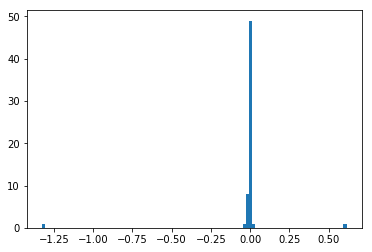

In [12]:
print(averages)
plt.hist(averages, bins=100)
plt.show()

In [13]:
X_train.head()

,ns2,ns5,ns8,ns11,s13,ns16,ns18,A11,A12,A13,...,A152,A153,A171,A172,A173,A174,A191,A192,A201,A202
0,6,1169,4,4,67,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0


In [14]:
X_train_fiddled.head()

,ns2,ns5,ns8,ns11,s13,ns16,ns18,A11,A12,A13,...,A152,A153,A171,A172,A173,A174,A191,A192,A201,A202
0,6,-55791.969590,4,4,67,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,48,175534.372043,2,2,22,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,12,113183.147343,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,104641.406824,2,4,45,1,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,24,157006.080062,3,4,53,2,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0


This doesn't make sense to me, as I computed elsewhere (in my compute_mutual_information notebook) that the mutual information between the target and feature `ns5` is high, and so prediction accuracy should be affected if it is randomised. I do not know why this happened :(

## 3. neural networks playground

In [15]:
from keras.models import Sequential
from keras.layers import Dense

# create model
model = ks.Sequential()
model.add(ks.layers.Dense(200, activation='relu', input_shape=(57,)))
model.add(ks.layers.Dense(100, activation='relu'))
model.add(ks.layers.Dense(50, activation='relu'))
model.add(ks.layers.Dense(1, activation='sigmoid'))
# early stopping
es = ks.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, 
          callbacks=[es], validation_split=0.5, validation_data=(X_val, y_val))

Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 1s 690us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 2/100
800/800 [==============================] - 0s 69us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 3/100
800/800 [==============================] - 0s 79us/step - loss: 0.2987 - val_loss: 0.2900
Epoch 4/100
800/800 [==============================] - 0s 80us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 5/100
800/800 [==============================] - 0s 83us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 6/100
800/800 [==============================] - 0s 94us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 00006: early stopping


800/800 [==============================] - 0s 54us/step
0.29 0.29875
dict_keys(['val_loss', 'loss'])


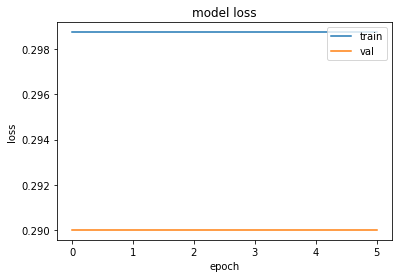

In [16]:
# evaluate the model
val_loss = model.evaluate(X_val, y_val)
train_loss = model.evaluate(X_train, y_train)
print(val_loss, train_loss)
# history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
print(model.predict(X_train[500:505]))
print(y_train[500:505])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
500    1
501    0
502    0
503    1
504    1
Name: y, dtype: int64


## Random interlude: boostrapping!

In [18]:
base_scores = np.abs(model.predict(X_val) - y_val.values.reshape((100,1)))

In [19]:
def permute(x):
    n = len(x)
    score = 0
    for i in range(n):
        index = np.random.randint(n)
        score += x[index]
    return score

def bootstrap(x, number_of_times):
    histogram = np.zeros((number_of_times, 1))
    for i in range(number_of_times):
        histogram[i] = permute(x)
    return histogram

In [20]:
distribution = bootstrap(base_scores, 10000)

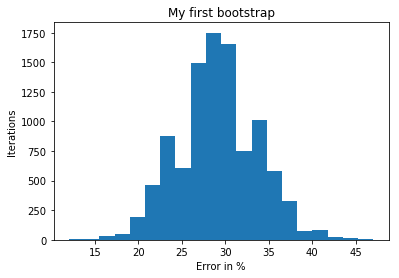

In [21]:
plt.hist(distribution, 20)
plt.title("My first bootstrap")
plt.ylabel("Iterations")
plt.xlabel("Error in %")
plt.show()

In [22]:
average = np.average(distribution)
var = np.var(distribution)
print("Average error is", average, "with variance", var)

Average error is 28.9845 with variance 20.741659750000004


In [23]:
print(X_train.columns)

Index(['ns2', 'ns5', 'ns8', 'ns11', 's13', 'ns16', 'ns18', 'A11', 'A12', 'A13',
       'A14', 'A30', 'A31', 'A32', 'A33', 'A34', 'A40', 'A41', 'A410', 'A42',
       'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A61', 'A62', 'A63', 'A64',
       'A65', 'A71', 'A72', 'A73', 'A74', 'A75', 'A101', 'A102', 'A103',
       'A121', 'A122', 'A123', 'A124', 'A141', 'A142', 'A143', 'A151', 'A152',
       'A153', 'A171', 'A172', 'A173', 'A174', 'A191', 'A192', 'A201', 'A202'],
      dtype='object')


# To do 

look into GANs to augment data 
read a paper real quick



In [24]:
print(np.shape(np.transpose(np.random.randn(800))))

(800,)


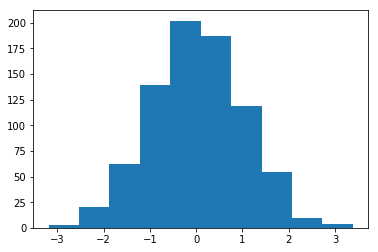

In [25]:
plt.hist(np.random.randn(800))
plt.show()

# Show that model can predict someones sex based on other features

In [26]:
X_train.head()

,ns2,ns5,ns8,ns11,s13,ns16,ns18,A11,A12,A13,...,A152,A153,A171,A172,A173,A174,A191,A192,A201,A202
0,6,1169,4,4,67,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0


In [27]:
model_unfiddled = fit_logistic_regression(X_train, sensitive[0:800])

print(model_unfiddled.score(X_val, sensitive[800:900]))
print(model_unfiddled.coef_)
X_val.columns

0.79
[[-1.43352611e-02  1.98813279e-04  3.69527786e-01  5.12321792e-03
   1.69435786e-02  4.76231759e-02  1.77272264e+00 -3.82873033e-01
  -2.78714902e-01  6.02742442e-02 -1.73570306e-01  8.10611685e-02
  -6.61966512e-01 -3.00358714e-01  2.78836015e-01 -1.72455955e-01
  -6.70532424e-02  2.54777199e-01  1.68490907e-01  4.95848286e-03
  -5.49909874e-02 -1.50380479e-01 -2.20097001e-01 -3.77192250e-01
  -3.40370904e-01  6.97427776e-03 -9.91830362e-02 -3.11257906e-01
   2.00611660e-01 -5.79067670e-01  1.40129543e-02 -3.15627975e-01
  -8.35647079e-01 -6.77512568e-02  2.01951304e-01  2.42191008e-01
  -4.75712748e-01 -8.86973535e-02 -2.10473897e-01 -4.83368026e-01
  -1.76930769e-01 -2.48348243e-01  1.33763040e-01 -4.01067178e-01
   4.94074721e-02 -4.23224292e-01 -8.83448766e-01  1.27259212e-01
  -1.86944437e-02 -2.97994701e-02 -2.23502976e-01 -1.08163151e-01
  -4.13418401e-01 -3.61225760e-01 -4.13658237e-01 -7.51499821e-01
  -2.33841770e-02]]


Index(['ns2', 'ns5', 'ns8', 'ns11', 's13', 'ns16', 'ns18', 'A11', 'A12', 'A13',
       'A14', 'A30', 'A31', 'A32', 'A33', 'A34', 'A40', 'A41', 'A410', 'A42',
       'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A61', 'A62', 'A63', 'A64',
       'A65', 'A71', 'A72', 'A73', 'A74', 'A75', 'A101', 'A102', 'A103',
       'A121', 'A122', 'A123', 'A124', 'A141', 'A142', 'A143', 'A151', 'A152',
       'A153', 'A171', 'A172', 'A173', 'A174', 'A191', 'A192', 'A201', 'A202'],
      dtype='object')

In [28]:
model_unfiddled = fit_logistic_regression(X_train, sensitive[0:800])

print(model_unfiddled.score(X_val, sensitive[800:900]))
print(model_unfiddled.coef_)


0.79
[[-1.44990989e-02  2.00551341e-04  3.71235615e-01  7.83729756e-03
   1.69528794e-02  2.07427267e-02  1.73453617e+00 -3.81390683e-01
  -2.87859575e-01  9.15967618e-02 -1.58811700e-01  9.36780318e-02
  -6.27581720e-01 -3.08293265e-01  2.87913611e-01 -1.82181854e-01
  -8.74194202e-02  2.30183662e-01  1.31112755e-01  8.12801842e-03
  -5.82515670e-02 -1.33153045e-01 -1.65139923e-01 -3.79049625e-01
  -2.77643321e-01 -5.23273115e-03 -1.04157447e-01 -3.15514398e-01
   2.04756141e-01 -5.40692957e-01  1.91434648e-02 -2.90008761e-01
  -8.04893795e-01 -8.10371543e-02  1.90956821e-01  2.48517693e-01
  -4.83116522e-01 -7.47929145e-02 -1.78555760e-01 -4.64504396e-01
  -1.62569953e-01 -2.09786622e-01  1.00395774e-01 -3.92224730e-01
   7.67713500e-02 -4.21011816e-01 -8.80776765e-01  1.16820935e-01
   2.74906336e-02 -4.35767681e-02 -2.00945056e-01 -8.57004435e-02
  -4.06242929e-01 -3.52796559e-01 -3.83668637e-01 -7.73894859e-01
   3.74296631e-02]]


So note that a standard logistic regression is capable of accurately classifying an individual by sex using her other attributes roughly 80% of the time. 

# Playing with an SVD

In [29]:
U, s, V = np.linalg.svd(X_train, full_matrices=False)
U_val, s_val, V_val = np.linalg.svd(X_val, full_matrices=False)

In [30]:
s1 = np.copy(s)
s2 = np.copy(s)
s3 = np.copy(s)

s1[1:-1] = 0
s2[5:-1] = 0
s3[10:-1] = 0

reconstructed1 = U@np.diag(s1)@V
reconstructed2 = U@np.diag(s2)@V
reconstructed3 = U@np.diag(s3)@V

s1_val = np.copy(s_val)
s2_val = np.copy(s_val)
s3_val = np.copy(s_val)

s1_val[1:-1] = 0
s2_val[5:-1] = 0
s3_val[10:-1] = 0

reconstructed1_val = U_val@np.diag(s1_val)@V_val
reconstructed2_val = U_val@np.diag(s2_val)@V_val
reconstructed3_val = U_val@np.diag(s3_val)@V_val

In [31]:
print(np.linalg.norm(reconstructed1-X_train))
print(np.linalg.norm(reconstructed2-X_train))
print(np.linalg.norm(reconstructed3-X_train))

811.3338270715302
73.4956242952245
58.83354375084583


In [32]:
print(reconstructed1[3])
print(X_train.iloc[[3]])

[3.87443787e+01 7.88197737e+03 3.86472035e+00 4.10725532e+00
 5.07369777e+01 2.01427849e+00 1.64056570e+00 3.55513278e-01
 4.78817688e-01 6.45896272e-02 5.26899475e-01 8.95389377e-02
 6.91164951e-02 6.94964030e-01 1.65299000e-01 4.06901605e-01
 3.05028455e-01 2.28442847e-01 3.58738840e-02 2.40436836e-01
 3.17849267e-01 7.10128685e-03 3.13384052e-02 7.99068845e-02
 5.56314069e-03 1.74279061e-01 8.20881156e-01 1.75965959e-01
 6.32094215e-02 5.97124479e-02 3.06051084e-01 1.03544134e-01
 2.26155463e-01 4.65947566e-01 2.71197503e-01 3.58975401e-01
 1.29371422e+00 7.36285820e-02 5.84772678e-02 2.75344298e-01
 2.91747212e-01 5.06704672e-01 3.52023885e-01 2.14460372e-01
 6.81035623e-02 1.14325613e+00 2.43128524e-01 9.37361657e-01
 2.45329886e-01 2.52811673e-02 2.13476992e-01 8.31395842e-01
 3.55666066e-01 6.77322498e-01 7.48497569e-01 1.39376240e+00
 3.20576672e-02]
   ns2   ns5  ns8  ns11  s13  ns16  ns18  A11  A12  A13  ...   A152  A153  \
3   42  7882    2     4   45     1     2    1    0  

In [34]:
model_run1 = fit_logistic_regression(reconstructed1, y_train)
model_run2 = fit_logistic_regression(reconstructed2, y_train)
model_run3 = fit_logistic_regression(reconstructed3, y_train)

print(model_run1.score(reconstructed1_val, y_val), "first model")
print(model_run2.score(reconstructed2_val, y_val), "second model")
print(model_run3.score(reconstructed3_val, y_val), "third model")

0.72 first model
0.73 second model
0.77 third model


# Make sure all is well and nobody is discriminating:

In [60]:
evaluate = pd.DataFrame(raw_data)
#get indices
females1 = evaluate['s9']=='A92'
females2 = evaluate['s9']=='A95'
males1 = evaluate['s9']=='A91'
males2 = evaluate['s9']=='A93'
males3 = evaluate['s9']=='A94'

In [69]:
flunk= fit_logistic_regression(females1[0:800].reshape(-1, 1), evaluate['y'][0:800])
print(flunk.score(females1[800:900].reshape(-1, 1), evaluate['y'][800:900]))

0.71


/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
